In [ ]:
##此代码画最佳的随机森林图

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn import metrics
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
import os
import xlsxwriter
from scipy import stats
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] = False
plt.subplots_adjust(wspace=0, hspace=150)
plt.tight_layout()

running_num = 1000
fig_rows = 1
fig_cols = 1
training_proportion_range = [0.7]
testing_pro = 0.3
data_num = 22
test_num = int(data_num * testing_pro)
cov = [0 for tt in range(data_num)]
my_test_pred = [ [] for tt in range(data_num)]
factors2 = ('chla','DIN','WS')
factors1 = ('chla','DIN','WS','Current','temp')
factors3 = ('chla','DIN','WS','DIN_SD','chla_SD')
factors_all = ('chla', 'temp', 'DIN', 'density', 'chla_SD', 'std_temp_SD', 'DIN_SD', 'density_SD', 'WS', 'Current')
factors_best = ('chla_SD', 'std_temp_SD', 'DIN_SD', 'density_SD', 'WS')

<Figure size 432x288 with 0 Axes>

In [2]:
#这里的real和pred都是np.array格式，默认传入的real和pred的size一样
#算NSE
def cal_NSE(real, pred, mean):
    numerator=0
    denominator=0
    for it in range(len(real)):
        numerator += (pred[it]-real[it]) ** 2
        denominator += (real[it]-mean) ** 2
    nse = 1 - numerator/denominator
    return nse

#算RMSE
def cal_RMSE(real, pred):
    n = len(pred)
    numerator = 0
    for it in range(len(pred)):
        numerator += (pred[it] - real[it]) * (pred[it] - real[it])
    RMSE = (numerator/n) ** 0.5
    return RMSE

#算Pcorr,mean是所有数据的mean还是test的mean
def cal_Pcorr(real, pred, mean):
    pred_mean = pred.mean(axis=0)
    numerator=0
    denominator=0
    a = 0
    b = 0
    for it in range(len(pred)):
        numerator += (pred[it]-pred_mean)*(real[it]-mean)
        a += (pred[it]-pred_mean) ** 2
        b += (real[it]-mean) ** 2
    denominator = (a*b) ** 0.5
    Pcorr = numerator / denominator
    return Pcorr

def cal_Cov(pred, real):
    cov = 0
    #print(len(pred))
    for i in range(len(pred)):
        cov += pow((pred[i] - real),2)
    cov = cov / len(pred)
    return cov

In [3]:
#DataSet is the name of the DataSet
#Data contains P_val, NSE and RMSE
#workbook has been created in main function
def write_excel(workbook,sheet_name,total,nse_test_array, nse_train_array):    
    worksheet = workbook.add_worksheet(sheet_name) #create a sheet for DataSet
    worksheet.write(1,0,'test_data')
    worksheet.write(2,0,'train_data')
    worksheet.write(0,1,'nse_mean')
    worksheet.write(0,2,'nse_std')
    worksheet.write(0,3,'nse_min')
    worksheet.write(0,4,'nse_max')
    worksheet.write(1,1,nse_test_array[0])
    worksheet.write(1,2,nse_test_array[1])
    worksheet.write(1,3,nse_test_array[2])
    worksheet.write(1,4,nse_test_array[3])
    worksheet.write(2,1,nse_train_array[0])
    worksheet.write(2,2,nse_train_array[1])
    worksheet.write(2,3,nse_train_array[2])
    worksheet.write(2,4,nse_train_array[3])
    worksheet.write(4,0,'序号')
    worksheet.set_column('A:A',10)#设置第2列宽度为20像素
    #worksheet.write(3,1,'模型')
    worksheet.write(4,1,'Pcorr')
    worksheet.write(4,2,'NSE')
    worksheet.write(4,3,'RMSE')
    worksheet.write(4,4,'pvalue')
    for r in range(int(len(total))):
        worksheet.write(r+5,0,r)
        #worksheet.write(r+1,1,total[r]['factors_str'])
        worksheet.write(r+5,1,total[r]['pcorr'])
        worksheet.write(r+5,2,total[r]['nse'])
        worksheet.write(r+5,3,total[r]['rmse'])
        worksheet.write(r+5,4,total[r]['pvalue'])

In [4]:
#DataSet is the name of the DataSet
#Data contains P_val, NSE and RMSE
#workbook has been created in main function
def write_excel2(workbook,sheet_name,total,nse_test_array, nse_train_array,cov):    
    worksheet = workbook.add_worksheet(sheet_name) #create a sheet for DataSet
    worksheet.write(1,0,'test_data')
    worksheet.write(2,0,'train_data')
    worksheet.write(0,1,'nse_mean')
    worksheet.write(0,2,'nse_std')
    worksheet.write(0,3,'nse_min')
    worksheet.write(0,4,'nse_max')
    worksheet.write(1,1,nse_test_array[0])
    worksheet.write(1,2,nse_test_array[1])
    worksheet.write(1,3,nse_test_array[2])
    worksheet.write(1,4,nse_test_array[3])
    worksheet.write(2,1,nse_train_array[0])
    worksheet.write(2,2,nse_train_array[1])
    worksheet.write(2,3,nse_train_array[2])
    worksheet.write(2,4,nse_train_array[3])
    worksheet.write(0,6,'年份')
    worksheet.write(0,7,'Cov')
    for i in range(len(cov)):
        worksheet.write(i+1,6,cov['year_index'][i])
        worksheet.write(i+1,7,cov['cov'][i])
    worksheet.write(4,0,'序号')
    worksheet.set_column('A:A',10)#设置第2列宽度为20像素
    #worksheet.write(3,1,'模型')
    worksheet.write(4,1,'Pcorr')
    worksheet.write(4,2,'NSE')
    worksheet.write(4,3,'RMSE')
    worksheet.write(4,4,'pvalue')
    rmse_mean = 0
    for r in range(int(len(total))):
        worksheet.write(r+5,0,r)
        #worksheet.write(r+1,1,total[r]['factors_str'])
        worksheet.write(r+5,1,total[r]['pcorr'])
        worksheet.write(r+5,2,total[r]['nse'])
        worksheet.write(r+5,3,total[r]['rmse'])
        rmse_mean = rmse_mean + total[r]['rmse']
        worksheet.write(r+5,4,total[r]['pvalue'])
    rmse_mean = rmse_mean / len(total)
    return rmse_mean

In [5]:
# listing all file names: all .mat file in my computer are stored in ./data/ directory 
file_names = ['HI-04-16-17']
file_dir = 'C:/Users/admin/data1/'
dt = np.dtype([('factors_str',str,80), ('r_2_0', float), ('nse', float), ('rmse', float),\
    ('pcorr', float), ('test_y', np.ndarray), ('test_pred', np.ndarray),('train_pred', np.ndarray), ('pvalue',float), \
    ('window_size', int), ('training_proportion', float),('test_year',np.ndarray),('train_year',np.ndarray)])
year_cov = np.dtype([('year_index',list),('cov',list)])

selected_kinds:  ['chla', 'DIN', 'WS', 'Current', 'temp', 'year']
22
1000
1


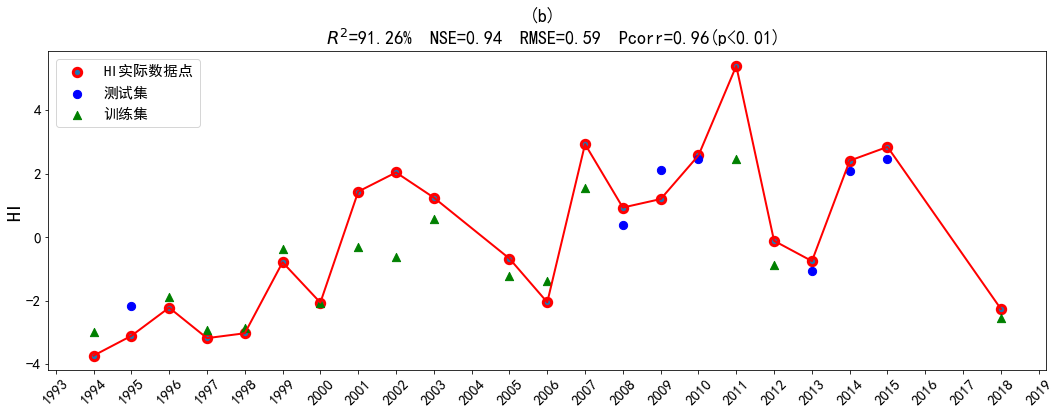

In [6]:
workbook = xlsxwriter.Workbook('HI_随机森林_3.xlsx') #create a excel table named result.xlsx
workbook2 = xlsxwriter.Workbook('HI_随机森林_3.xlsx') 
# reading data from .mat
performance = np.array([], dtype=year_cov)
for name in file_names:
    for training_proportion in training_proportion_range:
        if training_proportion == 1:
            running_num = 10
        for window_size in [1]:
            file_path = file_dir + name + '.mat'
            data = loadmat(file_path)['X']
            data = pd.DataFrame(data, columns=('chla', 'temp', 'DIN', 'density', 'chla_SD', 'std_temp_SD', 'DIN_SD', 'density_SD', 'WS', 'Current', 'HI', 'year'))
            
            data = data.reset_index(drop=True)    ###for monthly
            # converting data type
            data['year'] = data['year'].astype('i4')
            #data['month'] = data['month'].astype('i4') #for monthly
            all_kinds = []
            #all_kinds.append(list(factors_all))
    
            all_kinds.append(list(factors1))
            all_kinds.append(list(factors2))

            Data = []
            for k in range(1):
                fig, subfigure = plt.subplots(fig_rows, fig_cols, figsize=(15 * fig_cols, 6 * fig_rows))
                subfigures = []
                subfigures.append(subfigure)

                all_rmse = []
                all_train_rmse = []
                all_test_rmse = []
                all_test_nse = []
                all_train_nse = []
                nse_test_array = []
                nse_train_array = []
                total = np.array([], dtype=dt)
                selected_kinds = all_kinds[k]
            
                factors_str = ''
                
                for i in selected_kinds:
                    factors_str += i
                    factors_str += ' '
                
                Data.append(factors_str)
                selected_kinds.append('year')
                print("selected_kinds: ",selected_kinds)
                # constructing datasets
                X = data[selected_kinds]
                Y = data['HI']
                selected_kinds.remove('year')
                total_NSE = 0
                
                for i in range(running_num):
                    all_train, all_test, Y_train, Y_test = train_test_split(X, Y, test_size=testing_pro, random_state=i)
                    X_train = all_train[selected_kinds]
                    X_test = all_test[selected_kinds]
                #data preprocessing: data standardization
                    X_mean = X_train.mean(axis=0)
                    X_std = X_train.std(axis=0)
                    Y_mean = Y_train.mean(axis=0)
                    Y_std = Y_train.std(axis=0)
                    X_train_norm = (X_train - X_mean) / X_std
                    Y_train_norm = (Y_train - Y_mean) / Y_std
                    X_test_norm = (X_test - X_mean) / X_std
                    Y_test_norm = (Y_test - Y_mean) / Y_std

                # 多元线性回归
                    clf = RandomForestRegressor(n_estimators=5,random_state=45,bootstrap=True)
                    clf.fit(X_train_norm, Y_train_norm)
                    test_pred = clf.predict(X_test_norm)
                    train_pred = clf.predict(X_train_norm)
                    clf_test_pred = test_pred * Y_std + Y_mean
                    clf_train_pred = train_pred * Y_std + Y_mean
                #计算R2
                    R_2_0 = metrics.r2_score(Y_test.values, clf_test_pred) 
                #计算NSE, RMSE, Pcorr
                    NSE_test = cal_NSE(Y_test.values, clf_test_pred, Y_mean)
                    NSE_train = cal_NSE(Y_train.values, clf_train_pred, Y_mean)
                    RMSE = cal_RMSE(Y_test.values, clf_test_pred)
                    RMSE_test = cal_RMSE(Y_test.values,clf_test_pred)
                    RMSE_train = cal_RMSE(Y_train.values,clf_train_pred)
                    pearson = stats.pearsonr(np.array(Y_test, dtype='float'), np.array(clf_test_pred, dtype='float'))
                    Pcorr = pearson[0]
                    pvalue = pearson[1]
                
                    Data.append(Pcorr)
                    Data.append(NSE_test)
                    Data.append(RMSE)
                    all_rmse.append(RMSE)
                    all_test_rmse.append(RMSE_test)
                    all_train_rmse.append(RMSE_train)
                    all_test_nse.append(NSE_test)
                    all_train_nse.append(NSE_train)
                
                    test_year = all_test['year'][:]
                    train_year = all_train['year'][:]
                
                    for mm in range(test_num):
                        my_test_pred[test_year.index[mm]].append(clf_test_pred[mm]) 
                        
                    item = (factors_str, R_2_0, NSE_test, RMSE, Pcorr, Y, clf_test_pred, clf_train_pred, pvalue, window_size, training_proportion, test_year, train_year)
                    total = np.append(total, np.array(item, dtype=dt))

                for mm in range(data_num):
                    cov[mm] = cal_Cov(my_test_pred[mm],data['HI'][mm])
                    item2 = (mm+1994,cov[mm])
                    performance = np.append(performance,np.array(item2,dtype = year_cov))
                
                print(len(performance))
                print(len(total))
                nse_test_mean = np.mean(all_test_nse)
                nse_test_std = np.std(all_test_nse,ddof = 1)
                rmse_train_std = np.std(all_train_rmse,ddof=1)
                rmse_train_mean = np.mean(all_train_rmse)
                rmse_test_std = np.std(all_test_rmse,ddof=1)
                rmse_test_mean = np.mean(all_test_rmse)
                rmse_std = np.std(all_rmse,ddof=1)
                nse_test_sorted = sorted(all_test_nse)
                nse_test_max = nse_test_sorted[len(nse_test_sorted)-1]
                nse_test_min = nse_test_sorted[0]
                nse_test_array.append(nse_test_mean)
                nse_test_array.append(nse_test_std)
                nse_test_array.append(nse_test_min)
                nse_test_array.append(nse_test_max)
                
                nse_train_mean = np.mean(all_train_nse)
                nse_train_std = np.std(all_train_nse,ddof = 1)
                nse_train_sorted = sorted(all_train_nse)
                nse_train_max = nse_train_sorted[len(nse_train_sorted)-1]
                nse_train_min = nse_train_sorted[0]
                nse_train_array.append(nse_train_mean)
                nse_train_array.append(nse_train_std)
                nse_train_array.append(nse_train_min)
                nse_train_array.append(nse_train_max)         
                
    # sort the predicted results by NSE
                total = np.sort(total, kind='mergesort', order='nse')
                total = np.flipud(total)
                #print(total)
                performance = np.sort(performance, kind = 'mergesort',order='cov')
                #print(performance)
                write_excel(workbook, factors_str, total, nse_test_array, nse_train_array)#write result into excel file
                rmse_mean = write_excel2(workbook2, factors_str, total, nse_test_array, nse_train_array,performance)
#    workbook.close() #close excel file
                for kk in range(1):
                    # 建立时间戳，作为图表下标
                    if kk == 0:
                        m = 0
                    else:
                        m = len(total) - 1
                    window_size = total[m]['window_size']
                    training_proportion = total[m]['training_proportion']
                    years = list(data['year'])
                    test_years = total[m]['test_year']
                    train_years = total[m]['train_year']
                    x = [str(year) for year in years]
                    x = [datetime.strptime(i, '%Y') for i in x]
                    x = matplotlib.dates.date2num(x)
                    test_x = [str(year) for year in test_years]
                    test_x = [datetime.strptime(i, '%Y') for i in test_x]
                    test_x = matplotlib.dates.date2num(test_x)
                    train_x = [str(year) for year in train_years]
                    train_x = [datetime.strptime(i, '%Y') for i in train_x]
                    train_x = matplotlib.dates.date2num(train_x)
        # 实际值与预测值对比图
                    print(total[m]['window_size'])
                    plt.subplots_adjust(wspace=0, hspace=0.4)
                    plt.ylabel("HI",size=20)
                    subfigures[kk].plot(x, data['HI'], 'r-',linewidth = 2, label='')
                    subfigures[kk].scatter(x, data['HI'], marker='o', edgecolor='r', s=70, linewidths=3, label='HI实际数据点')
                    subfigures[kk].scatter(test_x, total[m]['test_pred'],s=68, label='测试集',color = 'b')
                    subfigures[kk].scatter(train_x, total[m]['train_pred'],s=68, label='训练集',color = 'g',marker='^' )
                    subfigures[kk].set_xticklabels(labels=x, rotation=45, size = 15)
                    subfigures[k].tick_params(labelsize=15)
                    subfigures[kk].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
                    subfigures[kk].xaxis.set_major_locator(matplotlib.dates.YearLocator())
                    subfigures[kk].legend(loc='best')
                    subfigures[kk].set_title('(b) \n $R^2$={3}%  NSE={0}  RMSE={1}  Pcorr={2}(p<0.01)'.format(\
             round(total[m]['nse'],2), round(total[m]['rmse'],2), round(total[m]['pcorr'],2), \
            round(total[m]['r_2_0']* 100, 2)),size=18)
                    subfigures[kk].legend(loc='upper left')
                plt.tight_layout()
                plt.savefig('HI_随机森林_'+ '最佳预测模型' +'.pdf')
                plt.savefig('HI_随机森林_'+ '最佳预测模型' +'.png')
workbook.close() #close excel file
workbook2.close()

In [7]:
print("test nse mean:")
print(nse_test_mean)
print("train nse mean:")
print(nse_train_mean)

test nse mean:
0.5324404138037974
train nse mean:
0.8786517678318967


In [8]:
print(rmse_test_mean)
print(rmse_train_mean)
print(rmse_train_std)
print(rmse_test_std)

1.6361664601385975
0.8171780451571831
0.1695562096828993
0.4292943757233019


In [9]:
print(rmse_std)
print(nse_train_std)
print(nse_test_std)

0.4292943757233019
0.053108176878259736
0.290466190191358
